In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])
from scipy.special import erf
import ROOT
import itertools
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import LinearNDInterpolator

_outdir='/eos/user/p/psilva/www/HGCal/TimingStudies/'

Welcome to JupyROOT 6.26/08


# 1. Parametrization of the time tagging efficiencies

In [ ]:
params={
    'SingleK0L':{
        'eff_W':{
            1.8:[3.154,17.1435E-2,4.5366E-4],
            2.0:[2.232,19.5095E-2,5.5182E-4],
            2.5:[1.694,20.7387E-2,5.0251E-4],
            2.8:[0.075,74.8389E-2,-37.7953E-4]
        },
        'eff_O':{
            1.8:[-0.031,22.9570E-2,6.3563E-4],
            2.0:[-0.648,31.5E-2,8.268E-4],
            2.5:[-0.086,28.6039E-2,10.2856E-4],
            2.8:[-7.213,110.2072E-2,-30.8232E-4]  
        },
        'eff_M':{
            1.8:[0.995,0.0036E-2,-0.0328E-4],
            2.0:[0.994,0.0116E-2,-0.0382E-4],
            2.5:[0.994,0.0153E-2,-0.0420E-4],
            2.8:[0.978,0.1858E-2,-0.4892E-4]  
        },
        'res_B':{
            1.8:[384.273, 190.3835E-2, -48.3130E-4],
            2.0:[411.308,556.4646E-2,-481.7102E-4],
            2.5:[424.853,685.9459E-2,-644.9183E-4],
            2.8:[992.130,-1703.9424E-2,2671.3520E-4]
        },
        'res_C':{
            1.8:[20,0,0],
            2.0:[20,0,0],
            2.5:[20,0,0],
            2.8:[20.,0,0]
        },
    },
    'SinglePhoton':{
        'eff_W':{
            1.8:[1.325,-0.5020E-2,1.2039E-4],
            2.0:[0.680,1.3954E-2,0.6909E-4],
            2.5:[0.236,0.28758E-2,-0.5412E-4],
            2.8:[0.219,5.6864E-2,-1.1568E-4]
        },
        'eff_O':{
            1.8:[-1.247,7.7057E-2,-1.0965E-4],
            2.0:[-0.871,8.7338E-2,0.3776E-4],
            2.5:[-0.637,8.0112E-2,0.7631E-4],
            2.8:[-1.109,18.4410E-2,0.6865E-4]  
        },
        'eff_M':{
            1.8:[1,0,0],
            2.0:[1,0,0],
            2.5:[1,0,0],
            2.8:[1,0,0]  
        },
        'res_B':{
            1.8:[33.410,33.6367E-2,0],
            2.0:[50.105,8.0494E-2,0],
            2.5:[42.221,51.3622E-2,0],
            2.8:[99.988,0.0125E-2,0]
        },
        'res_C':{
            1.8:[20,0,0],
            2.0:[20,0,0],
            2.5:[20,0,0],
            2.8:[20.,0,0]
        },
    }
}
    
def _evalParam(x,y,key=('k0l','eff_width')):

    #build array of available pseudo-rapidities
    shower,pname=key
    available_eta=np.array([eta for eta in params[shower][pname]])
    
    #evaluate the polynomials as function of qtoa
    #using the closest pseud-rapidity
    xy,z=[],[]
    nrow,ncol=x.shape[0],y.shape[0]
    for i,j in itertools.product(range(nrow),range(ncol)):
        ix=x[i]
        iy=y[j]
        xy.append( (ix,iy) )
        idx = (np.abs(iy - available_eta)).argmin()
        iy=available_eta[idx]
        a,b,c=params[shower][pname][iy]
        z.append( a+b*ix+c*(ix**2) )

    #return array    
    z=np.array(z) 
    return xy,z

interp={}
for shower in params:
    if shower =='k0l' : continue
    for pname in params[shower]:

        qtoa=np.linspace(12,100,100)
        eta=np.array([1.5,1.8,2.0,2.5,2.8,3.0])
        
        #interpolate
        xy,z = _evalParam(qtoa,eta,key=(shower,pname))
        interp[(shower,pname)] = LinearNDInterpolator(xy, z)
        X = np.linspace(qtoa[0],qtoa[-1])
        Y = np.linspace(1.5,3.0)
        X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
        Z = interp[(shower,pname)](X, Y)
                        
        #show plot
        fig,ax=plt.subplots(1,2,figsize=(12,6))
        for ieta,(a,b,c) in params[shower][pname].items():
            iZ=a+b*qtoa+c*(qtoa**2)
            ax[0].plot(qtoa,iZ,label=rf'$\eta={ieta:3.1f}$')
        ax[0].grid()
        ax[0].legend(title=shower)
        ax[0].set_xlabel(r'$q_{TOA}$ [fC]')
        ax[0].set_ylabel(pname)
        img=ax[1].pcolormesh(X, Y, Z, shading='auto')
        plt.colorbar(img)
        ax[1].grid()
        ax[1].set_xlabel(r'$q_{TOA}$ [fC]')
        ax[1].set_ylabel('Pseudo-rapidity')
        fig.tight_layout()
        plt.savefig(f'{_outdir}/{shower}_{pname}.png')
        plt.close()

In [ ]:
def timeTagEff(en,q=12,h=2.0,isem=False):

    """illustrate weight based on the efficiency parameterization"""
    
    shower='SinglePhoton' if isem else 'SingleK0L'
    eff_W = interp[(shower,'eff_W')](q,h)
    eff_O = interp[(shower,'eff_O')](q,h)
    eff_M = interp[(shower,'eff_M')](q,h)
    
    x=(en-eff_O)/eff_W;
    w=0.5*eff_M*(1+erf(x))
    return w

def timeResol(en,q=12,h=2.0,isem=False):
    
    """illustrates the toa resolution"""

    shower='SinglePhoton' if isem else 'SingleK0L'
    res_A = 0.
    res_B = interp[(shower,'res_B')](q,h)
    res_C = interp[(shower,'res_C')](q,h)
    
    return np.sqrt(res_A*res_A/en + (res_B/en)**2 + res_C**2)

def timeResolWgt(en,q=12,h=2.0,isem=False):
    
    """illustrates the toa resolution"""
    
    dt=timeResol(en,q,h,isem)
    eff_plateau=1.0;
    t=(90.-dt)/20;
    w=0.5*(1+eff_plateau*erf(t))
    return w


def drawParameterizedWeights(draw_eta=2.0):
    eta_label=rf' $|\eta|$={draw_eta:3.1f}'

    fig,ax=plt.subplots(1,2,figsize=(12,6),sharey=True)
    for isem in [0,1]:
        xlin=np.linspace(0.5,50 if isem else 75,500)
        for q0 in [12,50,75]:
            g=ax[isem].plot(xlin,timeTagEff(xlin,q0,draw_eta,isem),label=rf'$\varepsilon_{{{q0}~fC}}$')[0]
            ax[isem].plot(xlin,timeResolWgt(xlin,q0,draw_eta,isem),ls='--',c=g.get_color(),label=rf'$\delta t_{{{q0}~fC}}$')
        ax[isem].legend(title=rf'e.m. showers' if isem else rf'hadronic showers' + eta_label,
                        loc='upper center',ncol=3,fontsize=16)
        ax[isem].grid()
    ax[isem].set_xlabel(r'Energy [GeV]')
    ax[0].set_ylabel('Weight')
    plt.ylim(0,1.5)
    plt.tight_layout()
    plt.savefig(f'{_outdir}/timetageff_{draw_eta*10:3.0f}.png')
    plt.close()

    fig,ax=plt.subplots(1,2,figsize=(12,6),sharey=True)
    for isem in [0,1]:
        xlin=np.linspace(0.5,25,500)
        ax[isem].plot(xlin,timeResol(xlin,12,draw_eta,isem),label='12 fC')
        ax[isem].plot(xlin,timeResol(xlin,50,draw_eta,isem),label='50 fC')
        ax[isem].plot(xlin,timeResol(xlin,75,draw_eta,isem),label='75 fC')
        ax[isem].legend(title=rf'e.m. showers' if isem else rf'hadronic showers' + eta_label,
                        loc='upper right',
                        fontsize=16)
        ax[isem].grid()
        ax[isem].set_xlabel(r'Energy [GeV]')
        #ax[isem].set_xscale('log')
        ax[isem].plot(xlin,90*np.ones_like(xlin),ls='--',c='gray')
    ax[0].set_ylabel('ToA resolution')
    plt.ylim(0,200)
    plt.tight_layout()
    plt.savefig(f'{_outdir}/toaresol_{draw_eta*10:3.0f}.png')
    plt.close()
    
for draw_eta in [1.8,2.0,2.5,2.8]:
    drawParameterizedWeights(draw_eta)

In [ ]:
#generate the 2D graph map to be used in the jet analysis
gr2d_eff = {}
for isem in [0,1]:
    for q0 in [12,20,24,30,40,50,60,70,80,100]:
        grkey="em" if isem else "had"
        grkey+=f'_{q0:d}'
        gr2d_eff[f'{grkey}_timetagwgt']=ROOT.TGraph2D()
        gr2d_eff[f'{grkey}_timeresolwgt']=ROOT.TGraph2D()
        for en in np.logspace(-1,3,100):
            for h in np.linspace(1.5,3.0,100):
                n=gr2d_eff[f'{grkey}_timetagwgt'].GetN()
                gr2d_eff[f'{grkey}_timetagwgt'].SetPoint(n,en,h,timeTagEff(en,q0,h,isem))
                gr2d_eff[f'{grkey}_timeresolwgt'].SetPoint(n,en,h,timeResolWgt(en,q0,h,isem))

#save all to file to use in jet analysis
fOut=ROOT.TFile.Open(f'{_outdir}/timeeff.root','RECREATE')
fOut.cd()
for k,gr in gr2d_eff.items():
    gr.Write(k)
fOut.Close()

# 2. Performance plots for the jet analysis

In [2]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
def compareConstituentsSpectra(idx=0,qtoa=12,idxtitle=None):

    canvas=[]
    garbage=[]
    for c,ctitle in [('chf','Charged hadrons'),('emf','e.m. particles'),('nhf','Neutral hadrons')]:

        canvas.append( ROOT.TCanvas(c,c,1200,600))
        canvas[-1].Divide(2,1)
    
        cdfframe=None
        frame=None
        leg=None
        for r in [4,2]:
            fIn=ROOT.TFile.Open(f'/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak{r}_vbfhgg_{qtoa}fC.root')

            hsig=fIn.Get(f"pu{idx}_{c}_en")
            hpu=fIn.Get(f"pu{idx}_pu{c}_en")
    

            if frame is None:
                p=canvas[-1].cd(1)
                garbage.append( hpu.Clone(r'frame{c}') )
                garbage[-1].Reset('ICE')
                garbage[-1].SetDirectory(0)
                garbage[-1].Draw()
                garbage[-1].GetYaxis().SetRangeUser(1,1.2*max(hsig.GetMaximum(),hpu.GetMaximum()/10))
                frame=garbage[-1]
                frame.GetYaxis().SetTitleSize(0.04)
                frame.GetXaxis().SetTitleSize(0.04)
                p.SetLogy()

                garbage.append(ROOT.TLegend(0.6,0.7,0.9,0.92,ctitle))
                garbage[-1].SetBorderSize(0)
                garbage[-1].SetFillStyle(0)
                garbage[-1].SetTextSize(0.04)
                leg=garbage[-1]
            
                p=canvas[-1].cd(2)
                garbage.append(garbage[-2].Clone())
                garbage[-1].SetDirectory(0)
                garbage[-1].GetYaxis().SetRangeUser(0,1)
                garbage[-1].Draw()
                cdfframe=garbage[-1]
                cdfframe.GetYaxis().SetTitle('CDF')
                cdfframe.GetYaxis().SetTitleSize(0.04)
                cdfframe.GetXaxis().SetTitleSize(0.04)

            def _cloneAndFormat(h,name,title,width,color,ls):
                h=h.Clone(name)
                h.SetDirectory(0)
                h.SetTitle(title)
                h.SetLineWidth(width)
                h.SetLineColor(color)
                h.SetLineStyle(ls)
                return h
        
            ls=1 if r==4 else 7
        
            p=canvas[-1].cd(1)
            garbage.append( _cloneAndFormat(hsig,f'{hsig.GetName()}{r}',f'Sig (R=0.{r})', 2,1,ls) )
            garbage[-1].Draw('histsame')
            leg.AddEntry(garbage[-1],garbage[-1].GetTitle(),'l')
            garbage.append( _cloneAndFormat(hpu,f'{hpu.GetName()}{r}',f'PU (R=0.{r}) / 10', 2,ROOT.kGreen+2,ls) )
            garbage[-1].Scale(1./10)
            garbage[-1].Draw('histsame')
            leg.AddEntry(garbage[-1],garbage[-1].GetTitle(),'l')
            p.SetGridx()
            p.SetGridy()
            p.SetLeftMargin(0.15)
            p.SetRightMargin(0.05)
            p.SetTopMargin(0.05)
        
            p=canvas[-1].cd(2)
            garbage.append( _cloneAndFormat(hsig,f'{hsig.GetName()}{r}_cdf',f'Sig (R=0.{r})', 2,1,ls) )
            garbage[-1].Scale(1./garbage[-1].Integral(0,garbage[-1].GetNbinsX()+1))
            garbage[-1]=garbage[-1].GetCumulative()
            garbage[-1].SetDirectory(0)
            garbage[-1].Draw('histsame')
            garbage.append( _cloneAndFormat(hpu,f'{hpu.GetName()}{r}_cdf',f'PU (R=0.{r})', 2,ROOT.kGreen+2,ls) )
            garbage[-1].Scale(1./garbage[-1].Integral(0,garbage[-1].GetNbinsX()+1))
            garbage[-1]=garbage[-1].GetCumulative()
            garbage[-1].SetDirectory(0)
            garbage[-1].Draw('histsame')

            p.SetGridx()
            p.SetGridy()
            p.SetLeftMargin(0.15)
            p.SetRightMargin(0.05)
            p.SetTopMargin(0.05)
        
        canvas[-1].cd(1)
        leg.Draw()
        txt=ROOT.TLatex()
        garbage.append(txt.DrawLatexNDC(0.2,0.88,idxtitle))
        garbage[-1].SetNDC()
        canvas[-1].SaveAs(f'{_outdir}/{c}spectra_timetag{idx}_{qtoa}fC.png')
    return canvas,garbage
        
for qtoa in [12,24,50]:
    compareConstituentsSpectra(-1,qtoa,'No weight')
    compareConstituentsSpectra(0,qtoa,f'Time tag (q>{qtoa} fC)')
    compareConstituentsSpectra(1,qtoa,f'#splitline{{Time tag (q>{qtoa} fC)}}{{#sigma_{{t}}<90 ps}}')

Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/HGCal/TimingStudies//chfspectra_timetag-1_12fC.png has been created
Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/HGCal/TimingStudies//emfspectra_timetag-1_12fC.png has been created
Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/HGCal/TimingStudies//nhfspectra_timetag-1_12fC.png has been created
Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/HGCal/TimingStudies//chfspectra_timetag0_12fC.png has been created
Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/HGCal/TimingStudies//emfspectra_timetag0_12fC.png has been created
Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/HGCal/TimingStudies//nhfspectra_timetag0_12fC.png has been created
Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/HGCal/TimingStudies//chfspectra_timetag1_12fC.png has been created
Info in <TCanvas::Print>: png file /eos/user/p/psilva/www/HGCal/TimingStudies//emfspectra_timetag1_12fC.png has been creat

In [55]:
def getDataFrameFrom(url='/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak2_vbfhgg.root',R=0.2):
    
    rdf=ROOT.RDataFrame('data',url)
                    
    #convert to pandas
    #unsigned integers need to be cast to integers otherwise pandas will complain
    columns=[str(c) for c in rdf.GetColumnNames()]
    npdf=rdf.AsNumpy(columns=columns)
    npdf['nPU']=npdf['nPU'].astype(int)
    df=pd.DataFrame(npdf,columns=columns)

    def _deltaR(eta1,phi1,eta2,phi2):
        """computes deltaR with periodic limit conditions"""
        deta=eta1-eta2
        dphi=phi1-phi2
        dphi=np.where(dphi>np.pi,dphi-2*np.pi,
                      np.where(dphi<-np.pi,dphi+2*np.pi,dphi))
        return np.hypot(deta,dphi)

    #cut on CaloJet
    mask=(df['Jet_pt']>20) & (np.abs(df['GenJet_eta'])>1.6) & (np.abs(df['GenJet_eta'])<2.8)

    #cut on matching quality
    deltaR_mask = _deltaR(df['Jet_eta'],df['Jet_phi'],df['GenJet_eta'],df['GenJet_phi'])<0.5*R
    deltaRPU_mask = _deltaR(df['PuJet_eta'],df['PuJet_phi'],df['GenJet_eta'],df['GenJet_phi'])<0.5*R
    
    #apply cuts
    mask &= deltaR_mask
    mask &= deltaRPU_mask
    df=df[mask]
    df.reset_index(inplace=True,drop=True)
    return df


df_dict={
    (0.2,12,False):getDataFrameFrom('/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak2_vbfhgg_12fC.root',0.2),
    (0.2,24,False):getDataFrameFrom('/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak2_vbfhgg_24fC.root',0.2),
    (0.2,50,False):getDataFrameFrom('/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak2_vbfhgg_50fC.root',0.2),
    (0.4,12,False):getDataFrameFrom('/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak4_vbfhgg_12fC.root',0.4),
    (0.4,12,True):getDataFrameFrom('/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak4_vbfhgg_12fC_neutonly.root',0.4),
    (0.4,24,False):getDataFrameFrom('/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak4_vbfhgg_24fC.root',0.4),
    (0.4,50,False):getDataFrameFrom('/eos/user/p/psilva/data/hgcal/timingstudies/jets_ak4_vbfhgg_50fC.root',0.4),
}
df_dict[(0.4,12,False)].head()

,GenJet_en,GenJet_eta,GenJet_phi,GenJet_pt,Jet_en,Jet_eta,Jet_phi,Jet_pt,PrunedGenJet_en,PrunedGenJet_eta,...,PuJet_eta,PuJet_nhf,PuJet_phi,PuJet_puchf,PuJet_puemf,PuJet_punhf,nPU,puMode,toaThr,toaWgtCat
0,147.274811,1.753773,3.252034,49.40625,147.274811,1.753773,3.252034,49.40625,146.719818,1.753222,...,1.851437,0.012448,3.222369,0.472560,0.115598,0.071150,138,0,-1,-1
1,147.274811,1.753773,3.252034,49.40625,147.274811,1.753773,3.252034,49.40625,146.719818,1.753222,...,1.785144,0.019447,3.245193,0.098271,0.030469,0.037321,138,0,12,0
2,147.274811,1.753773,3.252034,49.40625,147.274811,1.753773,3.252034,49.40625,146.719818,1.753222,...,1.764460,0.022035,3.255820,0.037633,0.018791,0.000000,138,0,12,1
3,147.274811,1.753773,3.252034,49.40625,147.274811,1.753773,3.252034,49.40625,146.719818,1.753222,...,1.766026,0.015041,3.268557,0.000000,0.225756,0.126176,138,1,-1,-1
4,147.274811,1.753773,3.252034,49.40625,147.274811,1.753773,3.252034,49.40625,146.719818,1.753222,...,1.765631,0.021472,3.249427,0.000000,0.034153,0.041208,138,1,12,0


In [64]:
def displayReponse(dfkeys,proc=r'VBF $H\rightarrow\gamma\gamma$',
                   refjet='GenJet',
                   puMode=0,
                   toaWgtCat=-1,
                   onlyPU=False,
                   outname=None):

    #energy,response,deltaEta
    en_bins=np.linspace(0,2000,25)
    r_bins=np.linspace(0.,4,50)
    eta_bins=np.linspace(1.6,2.8,20)
    deta_bins=np.linspace(0,0.2,60)
    if toaWgtCat>=0:
        r_bins=np.linspace(0.5,1.2,50)
        deta_bins=np.linspace(0,0.05,60)
        
    fig,ax=plt.subplots(2,2,figsize=(16,16))
    
    refDrawn=[]
    for k in dfkeys:
        
        r,toa,neutonly=k
        df=df_dict[k]
        baselabel=f'R={r},q>{toa}fC'
        if neutonly: baselabel+=',only neut.'
        mask=(df['puMode']==puMode) & (df['toaWgtCat']==toaWgtCat)
    
        if not r in refDrawn:
            alpha=r/0.4
            ax[0][0].hist(df[mask][f'{refjet}_en'],label=f'{refjet} (R={r})',histtype='step',lw=3,bins=en_bins,ec='k',alpha=alpha)
            ax[1][0].hist(np.abs(df[mask][f'{refjet}_eta']),label=f'{refjet} (R={r})',histtype='step',lw=3,bins=eta_bins,ec='k',alpha=alpha)
            refDrawn.append(r)

        hist_fmt={'histtype':'step','lw':2,'bins':en_bins}
        
        #energy spectra
        puls='-' if onlyPU else '--'
        if not onlyPU:
            g=ax[0][0].hist(df[mask]['Jet_en'],label=f'PU=0 ({baselabel})',**hist_fmt)[-1][0]
            ax[0][0].hist(df[mask]['PuJet_en'],label=f'PU=140 ({baselabel})',**hist_fmt,ec=g.get_ec(),ls=puls)
        else:
            g=ax[0][0].hist(df[mask]['PuJet_en'],label=f'PU=140 ({baselabel})',**hist_fmt,ls=puls)[-1][0]

        #response
        hist_fmt['bins']=r_bins
        if not onlyPU:
            ax[0][1].hist(df[mask]['Jet_en']/df[mask][f'{refjet}_en'],label=f'PU=0 ({baselabel})',**hist_fmt,ec=g.get_ec())
        ax[0][1].hist(df[mask]['PuJet_en']/df[mask][f'{refjet}_en'],label=f'PU=140 ({baselabel})',**hist_fmt,ec=g.get_ec(),ls=puls)
        
        #pseudo-rapidity
        hist_fmt['bins']=eta_bins
        if not onlyPU:
            ax[1][0].hist(np.abs(df[mask]['Jet_eta']),**hist_fmt,ec=g.get_ec())
        ax[1][0].hist(np.abs(df[mask]['PuJet_eta']),**hist_fmt,ec=g.get_ec(),ls=puls)

        #pseudo-rapidity difference
        hist_fmt['bins']=deta_bins
        if not onlyPU:
            ax[1][1].hist(np.abs(df[mask]['Jet_eta']-df[mask][f'{refjet}_eta']),**hist_fmt,ec=g.get_ec())
        ax[1][1].hist(np.abs(df[mask]['PuJet_eta']-df[mask][f'{refjet}_eta']),**hist_fmt,ec=g.get_ec(),ls=puls)

    ax[0][0].legend(title=proc,fontsize=18)
    ax[0][0].set_xlabel('Energy [GeV]')
    ax[0][1].set_xlabel(r'Response = $E / E_{ref}$')
    ax[1][0].set_xlabel(r'$|\eta|$')
    ax[1][1].set_xlabel(r'$\Delta\eta = \eta - \eta_{ref}$')
    for i,j in itertools.product([0,1],[0,1]):
        ax[i][j].set_ylabel('Jets')
        ax[i][j].grid()

    hep.cms.label(loc=0,rlabel='',ax=ax[0][0])
    fig.tight_layout()
    if outname is None:
        plt.show()
    else:
        plt.savefig(f'{_outdir}/{outname}.png')
        plt.close()
    
displayReponse([(0.2,12,False),(0.4,12,False)],outname='resp_raw_cone')
displayReponse([(0.2,12,False),(0.4,12,False)],toaWgtCat=1,onlyPU=True,outname='resp_tt_cone')
displayReponse([(0.2,12,False),(0.2,24,False),(0.2,50,False)],toaWgtCat=1,onlyPU=True,outname='resp_tt_r02_thr')
displayReponse([(0.4,12,False),(0.4,24,False),(0.4,50,False)],toaWgtCat=1,onlyPU=True,outname='resp_tt_r04_thr')
displayReponse([(0.4,12,False),(0.4,12,True)],toaWgtCat=1,onlyPU=True,outname='resp_tt_r04_pumode')

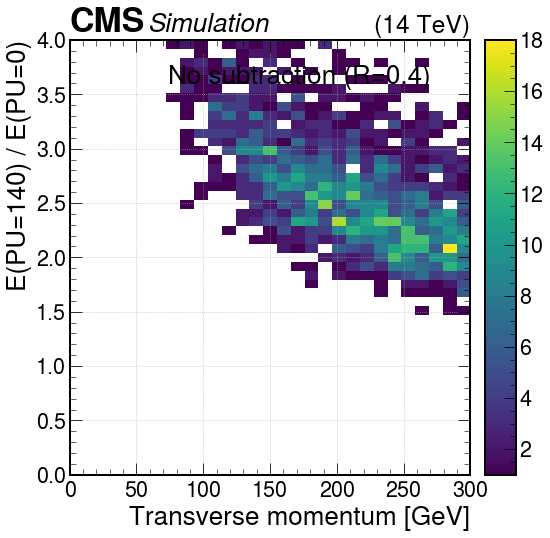

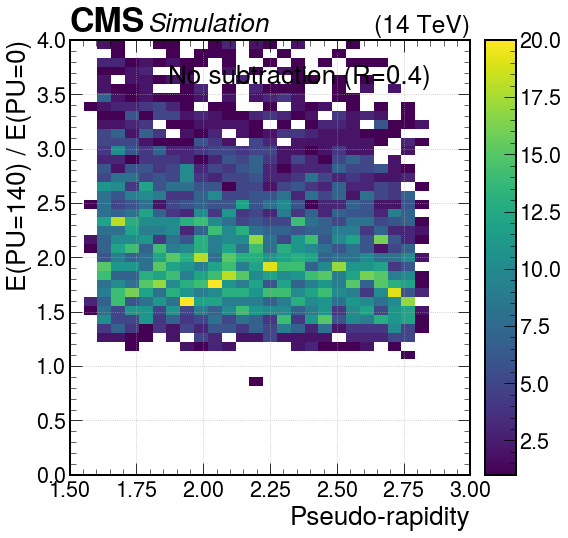

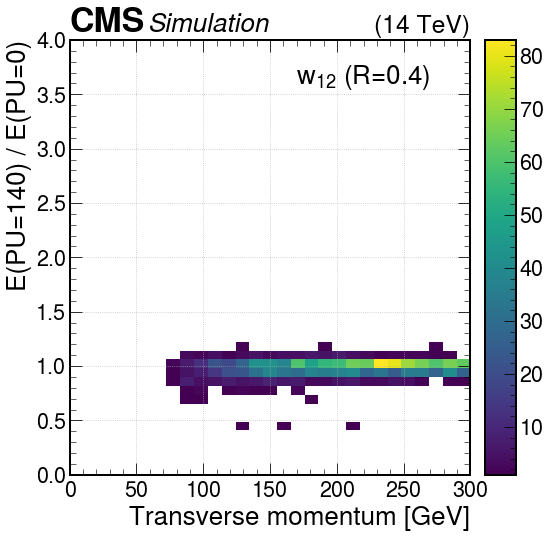

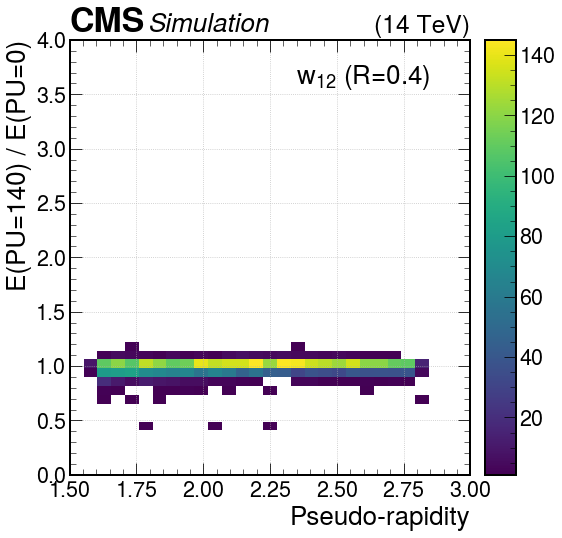

In [68]:
def show2Dresponse(R=0.4,qtoa=12,onlyneut=False,refjet='GenJet'):

    df=df_dict[(R,qtoa,onlyneut)]
    bins=(np.linspace(0,300,30),np.linspace(0,4,50))
    etabins=(np.linspace(1.5,3.0,30),np.linspace(0,4,50))
    for mask,title in [               
                     ((df['puMode']==0) & (df['toaThr']==-1.0),rf'No subtraction (R={R})'),  
                     ((df['puMode']==0) & (df['toaWgtCat']==1),rf'$w_{{{qtoa}}}$ (R={R})'),
                ]:
        H, xedges, yedges = np.histogram2d(df[mask][f'{refjet}_en'], 
                                           df[mask]['PuJet_en']/df[mask][f'{refjet}_en'], 
                                           bins=bins)
        fig, ax = plt.subplots(figsize=(8,8))
        hep.hist2dplot(H, xedges, yedges, labels=False,cmin=1)
        ax.set_xlabel('Transverse momentum [GeV]')
        ax.set_ylabel('E(PU=140) / E(PU=0)')
        hep.cms.label(loc=0,rlabel='(14 TeV)')
        ax.text(0.9,0.9,title,ha='right',transform=ax.transAxes)
        ax.grid()
        plt.show()
    
        H, xedges, yedges = np.histogram2d(np.abs(df[mask][f'{refjet}_eta']), 
                                           df[mask]['PuJet_en']/df[mask][f'{refjet}_en'], 
                                           bins=etabins)
        fig, ax = plt.subplots(figsize=(8,8))
        hep.hist2dplot(H, xedges, yedges, labels=False,cmin=1)
        ax.set_xlabel('Pseudo-rapidity')
        ax.set_ylabel('E(PU=140) / E(PU=0)')
        hep.cms.label(loc=0,rlabel='(14 TeV)')
        ax.text(0.9,0.9,title,ha='right',transform=ax.transAxes)
        ax.grid()
        plt.show()

show2Dresponse(qtoa=12)

In [78]:
from scipy.stats import crystalball

def response_model(x,a, mu,sigma, beta,m):
    t = (x - mu)/sigma
    return a*crystalball.pdf(t, beta, m)

"""
def gaussian(x, a, rinv, sigma):
    t = (x - rinv)/sigma
    return (a/(sigma*np.sqrt(2*np.pi))) * np.exp( - 0.5*(t**2) )
"""

def fitResponseWithModel(x,x0):

    #build the histogram 
    r=x/x0
    r=r[~np.isnan(r)]
    r=r[r>0.2]
    
    q=np.percentile(r,q=[5,16,50,84,99])
    med=q[2]
    wid=0.5*(q[3]-q[1])
    bins=np.linspace(q[0],q[-1],20)
    h, e = np.histogram(r, bins=bins)
    c = e[:-1] + np.diff(e) / 2
    #fit a gaussian to the bin centers
    #(normalization, mean, sigma, beta, m)
    #beta is the point in which the power law <-> gaussian transition occurs
    #m is the power of the power law 1/(B-x)**m
    bounds=((0,   max(med*0.8,q[1]), wid*0.8, q[1],  1),
            (1e6, min(med*1.2,q[3]), wid*1.2, q[-1], 10))
    try:
        popt,pcov = curve_fit(response_model, c[1:-1], h[1:-1],bounds=bounds,method='trf')
        isgood = True
    except:
        popt, pcov, isgood = None, None, False
        
    fit_report={'popt':popt,
                'pcov':pcov,
                'hist':h,
                'bin_edges':e, 
                'median':med,
                'sigmaeff':wid,
                'isgood':isgood}
    return fit_report


def calibrateEnergyResponse(df, base_mask_def, profq=np.linspace(0,95,15), doPlots=True, 
                            title='',refjet='GenJet',outname=None):
    
    df['CalibPuJet_en']=df['PuJet_en']
    
    #correct the jet response as function of the reconstructed energy
    if doPlots:
        ncols=int(len(profq)/2)
        fig,ax=plt.subplots(2,ncols,figsize=(30,10),sharex=True,sharey=True)
        
    fit_results=[]
    puMode,toaThr,toaWgtCat=base_mask_def
    base_mask = (df['puMode']==puMode)
    base_mask &= (df['toaThr']==toaThr)
    base_mask &= (df['toaWgtCat']==toaWgtCat)
    
    #divide equally the data to calibrate
    bins=np.percentile(df[base_mask]['PuJet_en'].values,q=profq)
    ymax=1
    for i in range(len(bins)-1):
        
        mask=(df['PuJet_en']>=bins[i]) & (df['PuJet_en']<bins[i+1]) & base_mask
        
        #fit response
        fit_report = fitResponseWithModel(x=df[mask]['PuJet_en'],x0=df[mask][f'{refjet}_en'])
        ymax=max(ymax,fit_report['hist'].max())
        goodFit = fit_report['isgood']
        #Ravg = fit_report['popt'][1] if goodFit else fit_report['median']
        #Ravg_unc = np.sqrt(fit_report['pcov'][1][1]) if goodFit else  fit_report['sigmaeff']/np.sqrt(mask.sum())
        Ravg = fit_report['median']
        Ravg_unc = fit_report['sigmaeff']/np.sqrt(mask.sum())
        fit_results.append([i,puMode,toaThr,toaWgtCat,
                            df[mask]['PuJet_en'].mean(),
                            df[mask][f'{refjet}_pt'].mean(),
                            df[mask][f'{refjet}_pt'].std(),
                            1/Ravg,
                            Ravg_unc/(Ravg**2),0,0])
                
        if not doPlots: continue
            
        #plot histogram
        irow=int(i/ncols)
        icol=i%int(ncols)
        iax=ax[irow][icol]
        bin_edges=fit_report['bin_edges']
        hep.histplot(fit_report['hist'], bin_edges, lw=1, color='gray', histtype='fill', ax=iax)
        if goodFit:
            iax.plot(bin_edges,response_model(bin_edges,*fit_report['popt']),color='blue',lw=1,ls='--')
        iax.text(0.1,0.9,rf'${bins[i]:3.0f}<E<{bins[i+1]:3.0f}$',ha='left',transform=iax.transAxes,fontsize=18)
        iax.text(0.1,0.8,f'1/R={1./Ravg:3.3f}',ha='left',transform=iax.transAxes,fontsize=18)       
        if i%2==1:
            iax.set_xlabel(r'$R=E_{calo}/E_{gen}$')

    #derive simple jet energy scale corrections
    jes=pd.DataFrame( fit_results,
                      columns=['i','puMode','toaThr','toaWgtCat',
                               'PuJet_en_mean',f'{refjet}_pt_mean',f'{refjet}_pt_std',
                               'Rinv','Rinv_unc','sigma','sigma_unc'] ) 
    spl = UnivariateSpline(x=jes['PuJet_en_mean'], y=jes['Rinv'], w=jes['Rinv_unc'], s=2, ext=3)
    
    #re-fit calibrated estimator to get final resolution
    jes['sigma']=0.
    jes['sigma_unc']=0. 
    for i in range(len(bins)-1):
        
        mask_jes = (jes['i']==i)
        if mask_jes.sum()!=1 : continue
        
        mask=(df['PuJet_en']>=bins[i]) & (df['PuJet_en']<bins[i+1]) & base_mask        
        x=df[mask]['PuJet_en']*spl(df[mask]['PuJet_en'].values)
        df.loc[mask,'CalibPuJet_en']=x
        x0=df[mask][f'{refjet}_en']
        fit_report = fitResponseWithModel(x=x,x0=x0)  
        ymax=max(ymax,fit_report['hist'].max())
        goodFit = fit_report['isgood']
        #sigmaR=fit_report['popt'][2] if goodFit else fit_report['sigmaeff']
        #sigmaR_unc= np.sqrt(fit_report['pcov'][2][2]) if goodFit else 0.
        sigmaR = fit_report['sigmaeff']
        sigmaR_unc =  np.sqrt((fit_report['sigmaeff']**2)/(2*mask.sum()))
        jes.loc[mask_jes,'sigma'] = sigmaR
        jes.loc[mask_jes,'sigma_unc'] = sigmaR_unc
            
        if not doPlots: continue
            
        #show calibrated response
        irow=int(i/ncols)
        icol=i%int(ncols)
        iax=ax[irow][icol]
        bin_edges=fit_report['bin_edges']
        hep.histplot(fit_report['hist'], bin_edges, lw=2, color='black', histtype='step', ax=iax)
        if goodFit:
            iax.plot(bin_edges,response_model(bin_edges,*fit_report['popt']),color='red',lw=2,ls='-')
        iax.text(0.1,0.7,rf'$\sigma={sigmaR:3.3f}$',ha='left',transform=iax.transAxes,fontsize=18)
            
    if doPlots:
            
        #ensure same scale for all abcissa
        xmin=min([ax[i%2][int(i/2)].get_xlim()[0] for i in range(len(bins)-1)])
        xmax=max([ax[i%2][int(i/2)].get_xlim()[1] for i in range(len(bins)-1)])
        for i in range(len(bins)-1):
            ax[i%2][int(i/2)].set_xlim(xmin,xmax)
            ax[i%2][int(i/2)].grid()
            ax[i%2][int(i/2)].set_ylim(0,ymax*1.5)
        hep.cms.label(loc=0,rlabel='',ax=ax[0][0])
        ax[0][-1].text(0,1.1,title,transform=ax[0][-1].transAxes)
        plt.subplots_adjust(wspace=0, hspace=0)
        fig.tight_layout()
        if outname:
            plt.savefig(f'{_outdir}/{outname}.png')
            plt.close()
        else:
            plt.show()
    
    #return JES summary
    jes=jes.drop(columns=['i'])
    return jes

#loop over parameters of interest
jec={}
for r,df in df_dict.items():
    
    print(f'Running naive JEC for {r}')
    
    jec[r]=[]
    mask_list=[(0,r[1],1)]
    if r in [(0.2,12,False),(0.4,12,False)]:
        mask_list.append( (0,-1,-1) )
    for base_mask_def in mask_list:
        outname=f'jec_{r[0]}_{r[1]}_{r[2]}'
        outname=outname.replace('.','p')
        outname=outname.replace('-','m')
        if base_mask_def[1]==-1 :
            mode_title=rf'Raw (R={r[0]})'
            outname += '_raw'
        else:
            mode_title=rf'$w_{{{r[1]}}}$ (R={r[0]})'  
        
        jec[r].append( calibrateEnergyResponse(df,base_mask_def,doPlots=True,title=mode_title,outname=outname) )

    #join
    jec[r]=pd.concat(jec[r])
    fname=f'{_outdir}/jec_{r[0]}_{r[1]}_{r[2]}.h5'
    jec[r].to_hdf(fname,key='jer')
    print(f'\t...output in {fname}')

Running naive JEC for (0.2, 12, False)
	...output in /eos/user/p/psilva/www/HGCal/TimingStudies//jec_0.2_12_False.h5
Running naive JEC for (0.2, 24, False)
	...output in /eos/user/p/psilva/www/HGCal/TimingStudies//jec_0.2_24_False.h5
Running naive JEC for (0.2, 50, False)
	...output in /eos/user/p/psilva/www/HGCal/TimingStudies//jec_0.2_50_False.h5
Running naive JEC for (0.4, 12, False)
	...output in /eos/user/p/psilva/www/HGCal/TimingStudies//jec_0.4_12_False.h5
Running naive JEC for (0.4, 12, True)
	...output in /eos/user/p/psilva/www/HGCal/TimingStudies//jec_0.4_12_True.h5
Running naive JEC for (0.4, 24, False)
	...output in /eos/user/p/psilva/www/HGCal/TimingStudies//jec_0.4_24_False.h5
Running naive JEC for (0.4, 50, False)
	...output in /eos/user/p/psilva/www/HGCal/TimingStudies//jec_0.4_50_False.h5


In [98]:
#plot response
def plotFinalRinv(jec_keys, raw_mode, labels, refjet='GenJet', outname=None):

    fig,ax=plt.subplots(figsize=(8,8)) 
    
    for i,k in enumerate(jec_keys):
        ijec=jec[k]
        ebar_style={'marker':'o','elinewidth':1,'capsize':1,'ls':'none'}
        if raw_mode[i]:
            mask=(ijec['puMode']==0) & (ijec['toaThr']==-1) & (ijec['toaWgtCat']==-1) 
            ebar_style['color']='k'
        else:
            mask=(ijec['puMode']==0) & (ijec['toaThr']==k[1]) & (ijec['toaWgtCat']==1) 
        ax.errorbar(ijec[mask][f'{refjet}_pt_mean'], 
                    1./ijec[mask]['Rinv'], 
                    yerr=ijec[mask]['Rinv_unc']*(ijec[mask]['Rinv']**2), 
                    **ebar_style, 
                    label=labels[i])

    plt.ylabel('R = $E(PU=140)~/~E_{ref}$')
    plt.xlabel(r'GenJet $p_{T}$ [GeV]')
    plt.legend(ncol=2,loc='upper left')
    plt.grid()
    hep.cms.label(loc=0,rlabel='(14 TeV)')
    ax.set_xscale('log')
    ax.plot(ax.get_xlim(),[1,1],ls='-',color='gray',lw=2)
    fig.tight_layout()
    if outname:
        plt.savefig(f'{_outdir}/{outname}.png')
        plt.close()
    else:
        plt.show()
    
jec_keys=[(0.2,12,False),(0.2,12,False),(0.2,24,False),(0.2,50,False)]
raw_mode=[True,False,False,False]
labels=['Raw (R=0.2)',r'$w_{12}$',r'$w_{24}$',r'$w_{50}$']
plotFinalRinv(jec_keys,raw_mode,labels,outname='rinv_profile_02')

jec_keys=[(0.4,12,False),(0.4,12,False),(0.4,24,False),(0.4,50,False)]
raw_mode=[True,False,False,False]
labels=['Raw (R=0.4)',r'$w_{12}$',r'$w_{24}$',r'$w_{50}$']
plotFinalRinv(jec_keys,raw_mode,labels,outname='rinv_profile_04')

In [110]:
#profile jet energy resolution as function of the generator jet pT
jer={}
refjet='GenJet'
for r,df in df_dict.items():
    
    print(f'Running naive JER for {r}')
    
    jer[r]=[]
    mask_list=[(0,r[1],1)]
    if r in [(0.2,12,False),(0.4,12,False)]:
        mask_list.append( (0,-1,-1) )
    
    for imask_def,df_data in df.groupby(['puMode','toaThr','toaWgtCat']):
        if not imask_def in mask_list: continue
        puMode,toaThr,toaWgtCat = imask_def
        ptbins=np.percentile(df_data[f'{refjet}_en'].values,q=np.linspace(0,100,11))
        for i in range(len(ptbins)-1):
            mask=(df_data[f'{refjet}_en']>=ptbins[i]) & (df_data[f'{refjet}_en']<ptbins[i+1])
            x=df_data[mask]['CalibPuJet_en']
            x0=df_data[mask][f'{refjet}_en']
            fit_report = fitResponseWithModel(x=x,x0=x0) 
            sigmaR = fit_report['sigmaeff']
            sigmaR_unc =  np.sqrt((fit_report['sigmaeff']**2)/(2*mask.sum()))
            jer[r].append( [
                puMode,toaThr,toaWgtCat,
                df_data[mask][f'{refjet}_en'].mean(),
                sigmaR,
                sigmaR_unc] )
    jer[r] = pd.DataFrame(jer[r],columns=['puMode','toaThr','toaWgtCat',f'{refjet}_en_mean','sigma','sigma_unc'])

Running naive JER for (0.2, 12, False)
Running naive JER for (0.2, 24, False)
Running naive JER for (0.2, 50, False)
Running naive JER for (0.4, 12, False)
Running naive JER for (0.4, 12, True)
Running naive JER for (0.4, 24, False)
Running naive JER for (0.4, 50, False)


In [120]:
#plot resolution
def plotFinalResol(jer_keys, raw_mode, labels, refjet='GenJet', outname=None):

    fig,ax=plt.subplots(figsize=(8,8)) 
    
    for i,k in enumerate(jer_keys):
        ijer=jer[k]
        ebar_style={'marker':'o','elinewidth':1,'capsize':1,'ls':'none'}
        if raw_mode[i]:
            mask=(ijer['puMode']==0) & (ijer['toaThr']==-1) & (ijer['toaWgtCat']==-1) 
            ebar_style['color']='k'
        else:
            mask=(ijer['puMode']==0) & (ijer['toaThr']==k[1]) & (ijer['toaWgtCat']==1) 
        ax.errorbar(ijer[mask][f'{refjet}_en_mean'],
                    ijer[mask]['sigma'], 
                    yerr=ijer[mask]['sigma_unc'], 
                    **ebar_style, 
                    label=labels[i])

    plt.ylim(0.,0.4)
    plt.ylabel(r'Eff. width = $1/2\cdot(q_{86}-q_{16})$')
    plt.xlabel(r'GenJet energy [GeV]')
    plt.legend(ncol=2,loc='upper left')
    plt.grid()
    hep.cms.label(loc=0,rlabel='(14 TeV)')
    #ax.set_xscale('log')
    ax.set_xlim(100,700)
    fig.tight_layout()
    if outname:
        plt.savefig(f'{_outdir}/{outname}.png')
        plt.close()
    else:
        plt.show()
    
jer_keys=[(0.2,12,False),(0.2,12,False),(0.2,24,False),(0.2,50,False)]
raw_mode=[True,False,False,False]
labels=['Raw (R=0.2)',r'$w_{12}$',r'$w_{24}$',r'$w_{50}$']
plotFinalResol(jer_keys,raw_mode,labels,outname='jer_profile_02')

jer_keys=[(0.4,12,False),(0.4,12,False),(0.4,24,False),(0.4,50,False)]
raw_mode=[True,False,False,False]
labels=['Raw (R=0.4)',r'$w_{12}$',r'$w_{24}$',r'$w_{50}$']
plotFinalResol(jer_keys,raw_mode,labels,outname='jer_profile_04')